In [1]:
import uproot as up
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


/hpc/applications/anaconda/3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
branch_names=['trilep_type',
              'lep_ID_0','lep_ID_1','lep_ID_2',
              'lep_Pt_0','lep_Pt_1','lep_Pt_2',
              'lep_E_0','lep_E_1','lep_E_2','Ptll01','Ptll02','Ptll12',
              'lep_Eta_0','lep_Eta_1','lep_Eta_2',
              'lep_Phi_0','lep_Phi_1','lep_Phi_2',
              'lep_isolationPflowLoose_0','lep_isolationPflowLoose_1','lep_isolationPflowLoose_2',
              'lep_Mtrktrk_atPV_CO_0','lep_Mtrktrk_atPV_CO_1','lep_Mtrktrk_atPV_CO_2',
              'lep_RadiusCO_0','lep_RadiusCO_1','lep_RadiusCO_2',
              'met_met','Mll01','Mll02','Mll12','best_Z_Mll','minOSSFMll','minOSMll',
              'DRll01','DRll02','DRll12',
              'HT','HT_lep','HT_jets','lead_jetPt','sublead_jetPt','lead_jetE','sublead_jetE',
              'nJets_OR','nJets_OR_DL1r_85','nTaus_OR_Pt25_RNN',
              'DRl1jmin','DRl0jmin','DRjjMax',
              'DRl0j0','DRl0j1','DRl1j0','DRl1j1','DRl2j0','DRl2j1','DRj0j1',
              'mj0j1','ml0j0','ml0j1','ml1j0','ml1j1','ml2j0','ml2j1']


signal_events = up.open("hhml_signal.root")['nominal']
ttbar_events = up.open("ttbar.root")['nominal']
vv_events = up.open("vv.root")['nominal']
#print("Variables available: ",signal_events.keys())

df_signal = signal_events.pandas.df(branch_names)
df_ttbar = ttbar_events.pandas.df(branch_names)
df_vv    = vv_events.pandas.df(branch_names)


df_signal['class'] =0
df_ttbar['class'] =1
df_vv['class']=2


print("Total Signal events: ",len(df_signal))
print("Total ttbar events: ",len(df_ttbar))
print("Total VV events: ",len(df_vv))

#combine data
df_bkgrnd = df_ttbar.append(df_vv)
df = df_bkgrnd.append(df_signal)
#df = df_signal.append(df_bkgrnd)

df = df.sample(frac=1).reset_index(drop=True) # Sort 

# Separate class info from inputs (no cheating!)
y_df = df.pop('class')
y_df.tail()

Total Signal events:  25706
Total ttbar events:  7834
Total VV events:  504022


537557    2
537558    2
537559    2
537560    2
537561    2
Name: class, dtype: int64

In [3]:
len(df)

537562

In [4]:
df_bkgrnd

trilep_type  lep_ID_0  lep_ID_1  lep_ID_2       lep_Pt_0  \
entry                                                              
0                 3     -13.0      11.0      11.0   41678.710938   
1                 2     -13.0      13.0      11.0   20897.574219   
2                 2     -11.0      13.0      13.0   35760.429688   
3                 2     -13.0      13.0      11.0   29343.279297   
4                 2      11.0     -13.0     -13.0   29444.998047   
...             ...       ...       ...       ...            ...   
504017            1      13.0     -13.0     -13.0  101676.421875   
504018            2     -13.0      11.0      13.0   28084.240234   
504019            1      13.0     -13.0     -13.0   34660.015625   
504020            2      13.0     -11.0     -13.0   72139.929688   
504021            1     -13.0      13.0      13.0   57439.042969   

             lep_Pt_1      lep_Pt_2        lep_E_0        lep_E_1  \
entry                                                               
0        70449.453125  58543.980469   55343.687500  103808.070312   
1        55793.660156  19368.746094   23247.623047  276121.375000   
2        22252.988281  95551.296875   59168.765625   22886.486328   
3        54785.179688  28005.828125   36258.410156   65460.417969   
4        25108.388672  24565.421875   46605.023438   31059.531250   
...               ...           ...            ...            ...   
504017   41141.203125  17839.507812  136126.640625   41618.578125   
504018   30508.630859  35212.882812  195224.968750  130895.078125   
504019  108541.562500  27151.939453   73509.453125  133402.031250   
504020   27932.728516  23779.408203  284104.156250  114730.593750   
504021   87497.359375  15498.876953  140086.609375  117136.656250   

              lep_E_2  ...    DRl2j1    DRj0j1          mj0j1          ml0j0  \
entry                  ...                                                     
0       178966.812500  ...  5.624905  1.253655   88672.937500  194640.218750   
1        27589.101562  ...  2.698675  3.088724  462571.937500  154922.796875   
2       109633.000000  ...  2.710770  5.656757   36084.914062   84529.812500   
3        48849.339844  ...  4.874618  0.677692   30693.119141   46659.460938   
4        60592.988281  ...  2.164400  1.061437    8154.880859  123839.656250   
...               ...  ...       ...       ...            ...            ...   
504017   47570.406250  ...  2.378890  1.341242   48526.699219  128320.570312   
504018   79510.539062  ...  1.483116  3.369550    4230.147949   37961.371094   
504019   27848.095703  ...  2.903071  2.140609    9316.860352  158146.703125   
504020   74491.414062  ...  1.836880  1.931773   54492.773438  226090.453125   
504021   25134.787109  ...  6.003888  5.700899   54006.628906  163630.437500   

                ml0j1          ml1j0          ml1j1          ml2j0  \
entry                                                                
0       189937.343750  290933.656250  276512.656250  368531.937500   
1        62089.742188  538147.187500  119113.460938   27435.603516   
2        70428.718750   54106.945312   58383.144531  196897.531250   
3        36889.007812  106377.406250   83356.500000   52515.144531   
4          -12.986925   98825.960938     105.706528  160200.781250   
...               ...            ...            ...            ...   
504017  126554.281250   71867.078125   92627.742188   51208.070312   
504018      93.880646   62903.496094     -19.081175   72531.320312   
504019     106.951714  218717.015625      97.538467   55049.812500   
504020  122796.460938  142934.656250   76565.632812  111098.257812   
504021  154896.046875  177527.281250  150833.203125   29048.425781   

                ml2j1  class  
entry                         
0       377577.875000      1  
1       138627.562500      1  
2       164351.593750      1  
3        42120.269531      1  
4          106.694695      1  
...               ...    ...  
504017   41579.546875    

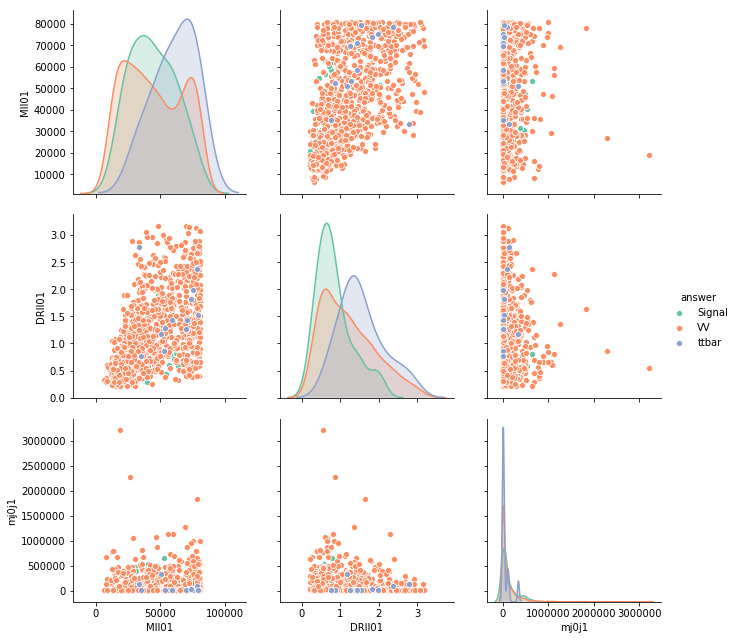

In [5]:
import seaborn as sns
# Seaborn is a nice package for data visualization - it has many pre-defined plotting functions and looks pretty

# Only keep some variables for training
variable_names = ['Mll01','DRll01','mj0j1']
#variable_names = branch_names

# Make a new column where the answer is a category with the appropriate name, for plotting
#df['answer']='CH3T'
df.loc[y_df==0,'answer']='Signal'
df.loc[y_df==1,'answer']='ttbar'
df.loc[y_df==2,'answer']='VV'
df['answer'] = df['answer'].astype('category')

# Plot input distributions and visualize correlations; only look at a subset of events for scatter plotting
g = sns.pairplot(df.head(1000), vars=variable_names, hue='answer', palette="Set2", height=3) # Diagonal plots are smoothed using kernel density estimator; skip with diag_kind='hist'

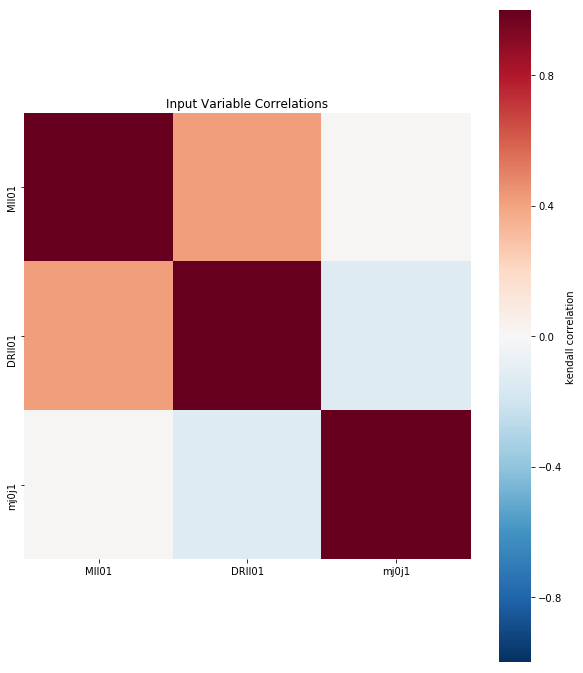

In [6]:
# Show correlation coefficients across variables
# Different correlation coefficients compared here: https://datascience.stackexchange.com/questions/64260/pearson-vs-spearman-vs-kendall
# Generically, Kendall only requires a monotonic relationship (not linear) and is more robust to outliers, as it only uses rank information (quantiles)
# Pearson includes a bit more information but assumes normal distributions and linear relationships
#method = 'pearson'
method = 'kendall'
correlations = df[variable_names].astype(np.float64).corr(method = method) # Kendall correlation coefficient ...
plt.figure(figsize = (10,12))
sns.heatmap(correlations, vmin = -1, annot = False, square = True, cbar_kws = {'label' : method+' correlation'}, cmap="RdBu_r")
plt.title('Input Variable Correlations')
plt.show()

In [7]:
#import seaborn as sns
#df['label'] = "ttbar"
#df.loc[y_df==1,"label"]="HH"
#df.loc[y_df==2,"label"]="VV"
#df["answer"] = df['label'].astype('category')
#g = sns.pairplot(df.sample(200), vars=branch_names,hue='label', palette="Set2", height=3)

In [8]:
#Split the samples into test and train.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


#Reduce to the variables we weant to train on 

X_train,X_test,y_train,y_test = train_test_split(df[branch_names],y_df,test_size=0.3)
#test  = xgb.DMatrix(data=test[variables_for_train],feature_names=variables_for_train)

In [9]:
#param_dist = {'eta':0.1,'max_depth':10,'eval_metric':'error','objective':'binary:logistic', 'n_estimators':100}
param_dist = {'num_class':3,
              'eta':0.1,
              'max_depth':10,
              'eval_metric':'error',
              'eval_metric':'auc',
              'objective':'multi:softprob',
              #'objective':'multi:softmax',
              #'objective':'binary:logistic',
              'tree_method':'gpu_hist',
              'n_estimators':5}

num_trees = 100
#model = XGBClassifier() 
#clf = xgb.XGBClassifier(**param_dist)
clf = xgb.XGBModel(**param_dist)
clf.fit(X_train, y_train)
#y_pred = XGBclassifier.predict(X_test)
#print (X_train.shape,y_train.shape)

XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=1, eta=0.1, eval_metric='auc',
         gamma=0, gpu_id=0, importance_type='gain', interaction_constraints='',
         learning_rate=0.100000001, max_delta_step=0, max_depth=10,
         min_child_weight=1, missing=nan,
         monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
         n_estimators=5, n_jobs=0, num_class=3, num_parallel_tree=1,
         objective='multi:softprob', random_state=0, reg_alpha=0, reg_lambda=1,
         scale_pos_weight=None, subsample=1, tree_method='gpu_hist',
         validate_parameters=1, verbosity=None)

In [10]:
y_test

468024    2
54732     2
81000     2
253019    2
456282    0
         ..
231386    2
223190    2
437458    2
455212    2
156065    2
Name: class, Length: 161269, dtype: int64

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

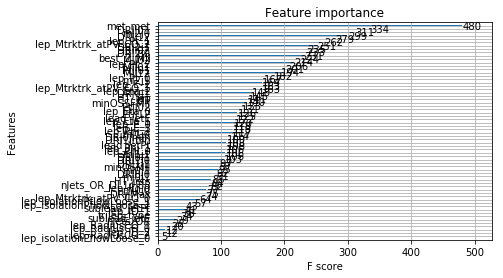

In [11]:
y_pred = clf.predict(X_test)
fig = plt.figure()
plt.figure(figsize = (20,12))
importance = xgb.plot_importance(clf)#, ax=plt.gca())
fig.subplots_adjust(left=0.4)

<Figure size 432x288 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

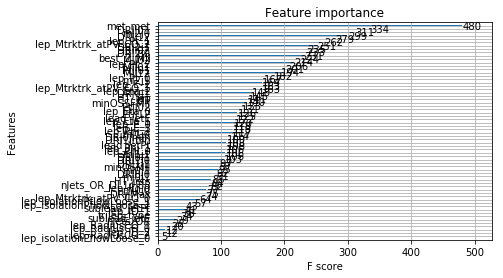

In [12]:
y_pred_train = clf.predict(X_train)
#fig = plt.figure()
plt.figure()
plt.figure(figsize=(15,10))
xgb.plot_importance(clf)#, ax=plt.gca())
#fig.subplots_adjust(left=0.4)
plt.show()

In [13]:
y_pred_vv_train

NameError: name 'y_pred_vv_train' is not defined

In [ ]:
#y_pred_test = model.decision_function(x_test_unscaled)
y_pred_DD_train = clf.predict(X_train[y_train==1])
y_pred_DD_test = clf.predict(X_test[y_test==1])
y_pred_ch3t_train = clf.predict(X_train[y_train==0])
y_pred_ch3t_test = clf.predict(X_test[y_test==0])
y_pred_vv_train = clf.predict(X_train[y_train==2])
y_pred_vv_test = clf.predict(X_test[y_test==2])







n_bins=50
hist_range=(0.2,0.6)
#DD_color = sns.color_palette("Set2")[1]
#CH3T_color = sns.color_palette("Set2")[0]
plt.figure(figsize=(12,10))




#data       = np.array(np.random.rand(1000))
#y,binEdges = np.histogram(data,bins=10)
#bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
#menStd     = np.sqrt(y)
#width      = 0.05
#plt.bar(bincenters, y, width=width, color='r', yerr=menStd)
#plt.show()


plt.hist(y_pred_DD_train[:,2],bins=n_bins,histtype='step',range=hist_range,density=True,alpha=0.4,color="green",label="Train, Signal")
counts,bin_edges = np.histogram(y_pred_DD_test[:,2],bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
#menStd     = np.sqrt(counts)
#plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='r.')
#plt.errorbar(x=0, xerr =0,y=counts, yerr=menStd)
plt.plot(bin_centers, counts,marker="o",linestyle="None",color="green",label="Test, Signal")


plt.hist(y_pred_vv_train[:,0],bins=n_bins,histtype='step',range=hist_range,density=True,alpha=0.4,color="blue",label="Train, VV")
counts,bin_edges = np.histogram(y_pred_vv_test[:,0],bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
#plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='r.')
plt.plot(bin_centers, counts,marker="o",linestyle="None",color="blue",label="Test, VV")


plt.hist(y_pred_ch3t_train[:,0],bins=n_bins,histtype='step',range=hist_range,density=True,alpha=0.4,color="red", label="Train, ttbar")
counts,bin_edges = np.histogram(y_pred_ch3t_test[:,0],bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
#plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='r.')
plt.plot(bin_centers, counts,marker="o",linestyle="None",color="red",label="Test, ttbar")

plt.legend()
plt.xlabel('BDT output')
plt.show()

In [ ]:
len(y_pred_train[2:])

In [ ]:
y_pred[;1]

In [ ]:
(X_train[y_train==0])

In [ ]:
#Plot predictions
plt.figure()
hist_range=(0.0,1.0)
plt.figure(figsize=(15,10))
#y_pred2 = clf_opt.predict(df_vv[branch_names])
#y_pred1 = clf.predict(df_signal[branch_names])
plt.hist(y_pred_train,bins=np.linspace(0.2,0.6,100),histtype='step',label='events')
#plt.hist(y_pred_train,bins=np.linspace(0.2,0.6,100),histtype='step',label='events')
counts,bin_edges = np.histogram(y_pred,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",label="Test, Signal")
#plt.hist(y_pred_DD_test,bins=np.linspace(0.2,0.6,100),histtype='step',label='All events')
#plt.plot(bin_centers, counts,marker="o",linestyle="None")#,color=DD_color,label="Test, Signal")

counts,bin_edges = np.histogram(y_pred,bins=100,range=hist_range,density=True)
plt.legend()
plt.xlabel("Prediction from BDT", fontsize=12)
plt.ylabel("Events",fontsize=12)
print(len(y_test),len(y_pred))

In [ ]:
#Plot predictions
plt.figure()
plt.figure(figsize=(10,5))
#plt.hist(y_pred,bins=np.linspace(0.2,0.6,100),histtype='step',label='All events')
plt.hist(y_pred,bins=np.linspace(0.2,0.6,100),histtype='step',label='events')
#plt.hist(y_pred_train,bins=np.linspace(0.2,0.6,100),histtype='step',label='All events')

#counts,bin_edges = np.histogram(y_pred,bins=100,range=hist_range,density=True)
plt.xlabel("Prediction from BDT", fontsize=12)
plt.ylabel("Events",fontsize=12)
print(len(y_test),len(y_pred))
print(y_test)
plt.legend()

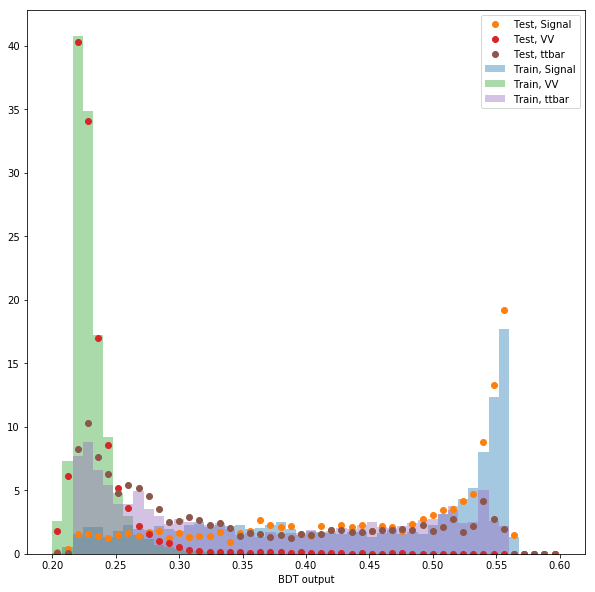

array([[0.3785009 , 0.2521681 , 0.36933103],
       [0.3531277 , 0.21685755, 0.4300148 ],
       [0.2256168 , 0.22266708, 0.5517161 ],
       ...,
       [0.2605578 , 0.21707454, 0.52236766],
       [0.43398994, 0.21406071, 0.3519494 ],
       [0.33084553, 0.2430143 , 0.42614016]], dtype=float32)

In [14]:
y_pred_DD_train = clf.predict(X_train[y_train==1])
y_pred_DD_test = clf.predict(X_test[y_test==1])
y_pred_ch3t_train = clf.predict(X_train[y_train==0])
y_pred_ch3t_test = clf.predict(X_test[y_test==0])
y_pred_vv_train = clf.predict(X_train[y_train==2])
y_pred_vv_test = clf.predict(X_test[y_test==2])


n_bins=50
hist_range=(0.2,0.6)
#DD_color = sns.color_palette("Set2")[1]
#CH3T_color = sns.color_palette("Set2")[0]
plt.figure(figsize=(10,10))

plt.hist(y_pred_DD_train[:,2],bins=n_bins,range=hist_range, density=True,alpha=0.4,label="Train, Signal")
counts,bin_edges = np.histogram(y_pred_DD_test[:,2], bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",label="Test, Signal")

plt.hist(y_pred_ch3t_train[:,1],bins=n_bins,range=hist_range,density=True,alpha=0.4,label="Train, VV")
counts,bin_edges = np.histogram(y_pred_ch3t_test[:,1], bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",label="Test, VV")

plt.hist(y_pred_ch3t_train[:,0],bins=n_bins,range=hist_range,density=True,alpha=0.4,label="Train, ttbar")
counts,bin_edges = np.histogram(y_pred_ch3t_test[:,0],bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",label="Test, ttbar")

plt.legend()
plt.xlabel('BDT output')
plt.show()
y_pred_ch3t_test

In [ ]:
y_pred_DD_train

In [ ]:
#Hyper parameter optimization
#https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning
import pickle
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        #'n_estimators': 100,
        'n_estimators': hp.quniform('n_estimators', 10, 500, 1),
        'objective':hp.choice('objective',['multi:softprob','multi:softmax']),
        #'objective':hp.choice('objective',['binary:logistic','binary:hinge']),
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(num_class=3,
                    objective= space['objective'],
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),tree_method='gpu_hist')
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,eval_metric="merror",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,space = space,algo = tpe.suggest, max_evals = 100,trials = trials)


In [ ]:
best_hyperparams

In [ ]:
best_hyperparams['num_class'] = 3
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams['n_estimators'] = int (best_hyperparams['n_estimators'])
best_hyperparams['tree_method'] = 'gpu_hist'
best_hyperparams['objective'] = "multi:softprob"
clf_opt = xgb.XGBModel(**best_hyperparams)
clf_opt.fit(X_train, y_train)

In [ ]:
y_pred = clf_opt.predict(X_test)
#y_pred = clf_opt.predict(df_vv[branch_names])
#y_pred1 = clf_opt.predict(df_signal[branch_names])
#Plot predictions
plt.figure()
plt.figure(figsize=(15,10))
plt.hist(y_pred,bins=np.linspace(0,1,50),histtype='step',label='All events')
plt.xlabel("Prediction from BDT", fontsize=12)
plt.ylabel("Events",fontsize=12)
#confusion_matrix(y_test,(y_pred>0.2))
#print([x[0] for x in y_pred],[x[1] for x in y_pred])
y_pred
#y_pred_sig = clf_opt.predict(X_train[y_train==0])
#y_pred_sig
print(y_pred[:,2])

In [ ]:
y_pred

In [ ]:
#y_pred_test = model.decision_function(x_test_unscaled)
y_pred_DD_train = clf_opt.predict(X_train[y_train==1])
y_pred_DD_test = clf_opt.predict(X_test[y_test==1])
y_pred_ch3t_train = clf_opt.predict(X_train[y_train==0])
y_pred_ch3t_test = clf_opt.predict(X_test[y_test==0])


n_bins=10
hist_range=(0,1.0)
DD_color = sns.color_palette("Set2")[1]
CH3T_color = sns.color_palette("Set2")[0]
plt.figure(figsize=(10,5))

plt.hist(y_pred_DD_train[:,2],bins=n_bins,range=hist_range,density=True,alpha=0.4,label="Train, Signal")
counts,bin_edges = np.histogram(y_pred_DD_test[:,2],bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",label="Test, Signal")

#plt.hist(y_pred_ch3t_train[:,0],bins=n_bins,range=hist_range,density=True,alpha=0.4,label="Train, VV")
#counts,bin_edges = np.histogram(y_pred_ch3t_test[:,0],bins=n_bins,range=hist_range,density=True)
#bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
#plt.plot(bin_centers, counts,marker="o",linestyle="None",label="Test, VV")

plt.hist(y_pred_ch3t_train[:,1],bins=n_bins,range=hist_range,density=True,alpha=0.4,label="Train, ttbar")
counts,bin_edges = np.histogram(y_pred_ch3t_test[:,1],bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",label="Test, ttbar")

plt.legend()
plt.xlabel('BDT output')
plt.show()
y_pred_ch3t_test

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
#print(classification_report(y_test, y_pred))


In [ ]:
#from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

#cv_clf = xgb.XGBClassifier(num_class=3,tree_method='gpu_hist')

#myParams = {
#    'min_child_weight':[1,5,10],
#    'learning_rate':[0.1,0.2,0.3,0.4,0.5],
#    'max_depth':[1,2,3,4,5,6,7,8,9,10],
#    'n_estimators':[10,100,120,150,200,250,300,350,400,500]
#}


#skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
#random_search = RandomizedSearchCV(cv_clf, 
#                                   param_distributions=myParams,
#                                   scoring='f1_macro',
#                                   n_jobs=10,
#                                   cv=skf.split(X_train,y_train),
#                                   verbose=1,random_state=1)

#random_search.fit(X_train,y_train)


In [ ]:
import pickle
pickle.dump(clf_opt,open("multi_class.xgb","wb"))

In [ ]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

In [ ]:
#cm = confusion_matrix(y_test, y_pred)
#cm



In [ ]:
#plot_confusion_matrix(cm, ['producer 1', 'producer 2', 'producer 3'])